In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [92]:
dataset = pd.read_csv('../../dataset/preprocessed.csv')

### Razdvajamo atribut Revanue od ostalih

In [93]:
X = dataset.drop(columns=['Revenue'])
y = dataset['Revenue']

### Podela skupa na train i test

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.3, stratify = y)
X_train_original = pd.DataFrame(X_train, columns = X.columns)

### Standardizacija

In [95]:
stand = StandardScaler()
X_train_scaled = stand.fit_transform(X_train)
X_test_scaled = stand.transform(X_test)

In [96]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns)
X_train_scaled.shape

(8442, 73)

In [97]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X.columns)
X_test_scaled.shape

(3618, 73)

### Prikaz nekih atributa pre i posle standardizacije

[Text(0.5, 0, ''), Text(0, 0.5, '')]

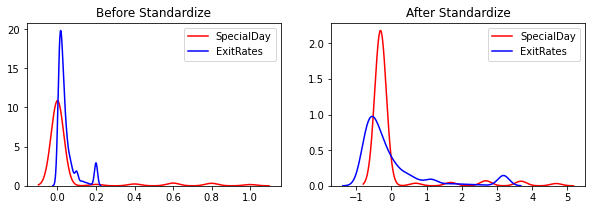

In [98]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))

sns.kdeplot(X_train_original['SpecialDay'], ax=ax1, label='SpecialDay', color='r')
sns.kdeplot(X_train_original['ExitRates'], ax=ax1, label='ExitRates', color='b')
ax1.set_title('Before Standardize')
ax1.legend(loc="upper right")
ax1.set(xlabel=None, ylabel=None)

sns.kdeplot(X_train_scaled['SpecialDay'], ax=ax2, label='SpecialDay', color='r')
sns.kdeplot(X_train_scaled['ExitRates'], ax=ax2, label='ExitRates', color='b')
ax2.set_title('After Standardize')
ax2.legend(loc="upper right")
ax2.set(xlabel=None, ylabel=None)

### Crtanje matrice

In [99]:
def cnf_matrix(y_pred_test, colormap): 
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                                        display_labels=[False, True])
    
    cm_display = cm_display.plot(cmap=colormap, values_format='g')


### Hiper parametri

In [100]:
params = {
    'n_estimators' : range(5, 20, 5),
    'criterion' : ['gini', 'entropy']
}

In [101]:
forest_classfier = RandomForestClassifier()
grid = GridSearchCV(estimator=forest_classfier, 
                    param_grid=params, 
                    cv=5, 
                    verbose=8)
grid.fit(X_train_scaled, y_train)
grid.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....criterion=gini, n_estimators=5;, score=0.870 total time=   0.1s
[CV 2/5] END ....criterion=gini, n_estimators=5;, score=0.887 total time=   0.1s
[CV 3/5] END ....criterion=gini, n_estimators=5;, score=0.889 total time=   0.1s
[CV 4/5] END ....criterion=gini, n_estimators=5;, score=0.883 total time=   0.1s
[CV 5/5] END ....criterion=gini, n_estimators=5;, score=0.891 total time=   0.1s
[CV 1/5] END ...criterion=gini, n_estimators=10;, score=0.892 total time=   0.2s
[CV 2/5] END ...criterion=gini, n_estimators=10;, score=0.892 total time=   0.2s
[CV 3/5] END ...criterion=gini, n_estimators=10;, score=0.889 total time=   0.1s
[CV 4/5] END ...criterion=gini, n_estimators=10;, score=0.892 total time=   0.2s
[CV 5/5] END ...criterion=gini, n_estimators=10;, score=0.899 total time=   0.1s
[CV 1/5] END ...criterion=gini, n_estimators=15;, score=0.889 total time=   0.2s
[CV 2/5] END ...criterion=gini, n_estimators=15;,

{'criterion': 'entropy', 'n_estimators': 15}

In [102]:
forest_classifier = RandomForestClassifier(criterion='entropy', n_estimators=15)
forest_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=15)

Train result: 0.9966832504145937
Test result: 0.8999447208402432

               precision    recall  f1-score   support

           0       0.92      0.97      0.94      3073
           1       0.75      0.50      0.60       545

    accuracy                           0.90      3618
   macro avg       0.83      0.74      0.77      3618
weighted avg       0.89      0.90      0.89      3618



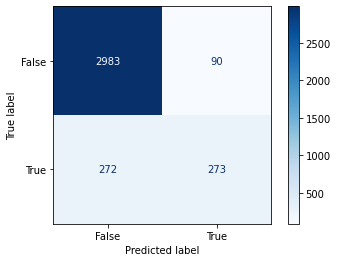

In [103]:
y_pred_train = forest_classifier.predict(X_train_scaled)
y_pred_test = forest_classifier.predict(X_test_scaled)
    
train_result = accuracy_score(y_train, y_pred_train)
print("Train result:", train_result)
test_result = accuracy_score(y_test, y_pred_test)
print("Test result:", test_result)
  
print("\n", classification_report(y_test, y_pred_test))

cnf_matrix(y_pred_test, plt.cm.Blues)

### Sada sa balansiranjem klasa

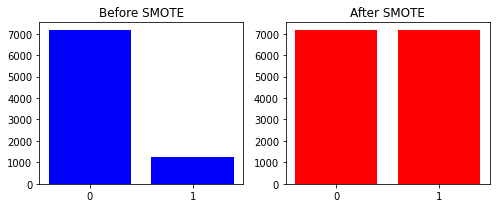

In [104]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7,3))
ax1.set_title('Before SMOTE')
ax1.bar(['0','1'], [sum(y_train == 0), sum(y_train == 1)], color = ['b', 'b'])

oversample = SMOTE(random_state = 2, sampling_strategy = 'minority')
X_train_smote, y_train = oversample.fit_resample(X_train_scaled, y_train.ravel())

ax2.set_title('After SMOTE')
ax2.bar(['0','1'], [sum(y_train == 0), sum(y_train == 1)], color = ['r', 'r'])

plt.tight_layout()

In [105]:
params = {
    'n_estimators' : range(5, 20, 5),
    'criterion' : ['gini', 'entropy']
}

In [106]:
forest_classfier = RandomForestClassifier()
grid = GridSearchCV(estimator=forest_classfier, 
                    param_grid=params, 
                    cv=5, 
                    verbose=8)
grid.fit(X_train_smote, y_train)
grid.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....criterion=gini, n_estimators=5;, score=0.822 total time=   0.1s
[CV 2/5] END ....criterion=gini, n_estimators=5;, score=0.950 total time=   0.1s
[CV 3/5] END ....criterion=gini, n_estimators=5;, score=0.943 total time=   0.1s
[CV 4/5] END ....criterion=gini, n_estimators=5;, score=0.948 total time=   0.1s
[CV 5/5] END ....criterion=gini, n_estimators=5;, score=0.945 total time=   0.2s
[CV 1/5] END ...criterion=gini, n_estimators=10;, score=0.833 total time=   0.2s
[CV 2/5] END ...criterion=gini, n_estimators=10;, score=0.956 total time=   0.2s
[CV 3/5] END ...criterion=gini, n_estimators=10;, score=0.960 total time=   0.2s
[CV 4/5] END ...criterion=gini, n_estimators=10;, score=0.960 total time=   0.2s
[CV 5/5] END ...criterion=gini, n_estimators=10;, score=0.960 total time=   0.2s
[CV 1/5] END ...criterion=gini, n_estimators=15;, score=0.854 total time=   0.2s
[CV 2/5] END ...criterion=gini, n_estimators=15;,

{'criterion': 'gini', 'n_estimators': 15}

In [107]:
forest_classifier = RandomForestClassifier(criterion='entropy', n_estimators=15)
forest_classifier.fit(X_train_smote, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=15)

Train result: 0.9983960948396094
Test result: 0.8977335544499724

               precision    recall  f1-score   support

           0       0.94      0.94      0.94      3073
           1       0.65      0.69      0.67       545

    accuracy                           0.90      3618
   macro avg       0.80      0.81      0.80      3618
weighted avg       0.90      0.90      0.90      3618



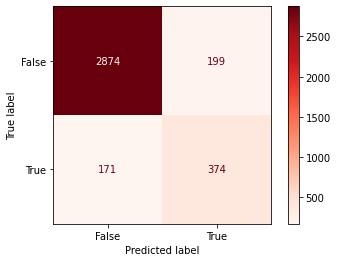

In [108]:
y_pred_train = forest_classifier.predict(X_train_smote)
y_pred_test = forest_classifier.predict(X_test_scaled)
    
train_result = accuracy_score(y_train, y_pred_train)
print("Train result:", train_result)
test_result = accuracy_score(y_test, y_pred_test)
print("Test result:", test_result)
  
print("\n", classification_report(y_test, y_pred_test))

cnf_matrix(y_pred_test, plt.cm.Reds)

In [109]:
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_test, y_pred_test)
roc_auc_forest = auc(fpr_forest, tpr_forest)

In [110]:
%store y_pred_test
%store fpr_forest
%store tpr_forest
%store threshold_forest
%store roc_auc_forest

Stored 'y_pred_test' (ndarray)
Stored 'fpr_forest' (ndarray)
Stored 'tpr_forest' (ndarray)
Stored 'threshold_forest' (ndarray)
Stored 'roc_auc_forest' (float64)
